In [132]:
import os

import torch
torch.manual_seed(12345)
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
print(torch.cuda.get_device_name())
from torch_scatter import scatter_add, scatter_mean, scatter_max
from torch_geometric.data import Data

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

1.9.0+cu111
NVIDIA GeForce RTX 2070 SUPER


# Edge Classification with Interaction Network
Previous: Node Classification with Graph Neural Network

This tutorial will teach you how to construct the Interaction Network and apply it to edge classification tasks. 



## Objective of the Interaction Network
We use a fraction of the [Tracking ML Challenge](https://www.kaggle.com/competitions/trackml-particle-identification/data) dataset for the demonstration purpose. The inputs to the Interaction Network is a pre-defined graph where nodes are detector measurements and edges are the links between two nodes. Edges are labeled as zero for "fake edges" and one for "true edges". Therefore, the objective of the Interaction Network is to solve the binary classification problem by assign a score to each edge.

## Visualize true graphs
True graphs are constructed by removing fake edges in the input graphs. 

In [4]:
fname = "datasets/21000"
data = torch.load(fname)

A utitlity function `view_graph` that helps to view the graphs

In [130]:
def view_graph(hits: np.ndarray, pids: np.ndarray, edges: np.ndarray,
    outname: str = None, markersize: int = 20, max_tracks: int = 10, with_legend=False):
    """View a graph of hits and edges.
    Args:
        hits: spacepoint positions in [r, phi, z]
        pids: particle id of each spacepoint
        edges: list of edges in dimension of [2, num-edges]
        outname: name of output file
        markersize: size of markers
        max_tracks: maximum number of tracks for visulization
    """
    unique_particles = np.unique(pids)
    do_only_nodes = False

    if max_tracks is not None and max_tracks > 0 and max_tracks < len(unique_particles)-1:
        sel_pids = unique_particles[1:max_tracks+1]
    else:
        sel_pids = unique_particles[1:]
        print("only plot the nodes!")
        do_only_nodes = True
        max_tracks = len(sel_pids) + 1

    print(f'randomly select {max_tracks} particles for display')
    all_sel_hits = hits[np.isin(pids, sel_pids)]
    all_sel_hit_idx = np.where(np.isin(pids, sel_pids))[0]
    print("{:,} out of {} hits are selected".format(
        all_sel_hits.shape[0], hits.shape[0]))

    def get_hit_info(X):
        r = X[:, 0]
        phi = X[:, 1]
        z = X[:, 2]
        x = r*np.cos(phi)
        y = r*np.sin(phi)
        return x,y,z,r,phi

    _, axs = plt.subplots(1, 2, figsize=(13, 6))

    # add edges
    if not do_only_nodes:
        axs = axs.flatten()
        for pid in sel_pids:
            sel_hits = hits[pids==pid]
            x, y, z, r, _ = get_hit_info(sel_hits)
            axs[0].scatter(x, y, s=markersize, label=str(pid))
            axs[1].scatter(z, r, s=markersize)

        if with_legend:
            axs[0].legend(fontsize=10)

        sel_edges = edges[:, np.isin(edges[0], all_sel_hit_idx) \
            & np.isin(edges[1], all_sel_hit_idx)]
        print("selected {:,} edges from total {:,} true edges".format(
            sel_edges.shape[1], edges.shape[1]))

        sel_edges = sel_edges.T
        for iedge in range(sel_edges.shape[0]):
            sel_hits = hits[sel_edges[iedge]]
            x, y, z, r, _ = get_hit_info(sel_hits)
            axs[0].plot(x, y, color='k', lw=2., alpha=0.5)
            axs[1].plot(z, r, color='k', lw=2., alpha=0.5)
    else:
        x, y, z, r, _ = get_hit_info(hits)
        axs[0].scatter(x, y, s=markersize)
        axs[1].scatter(z, r, s=markersize)
        # plot edges
        sel_edges = edges.T
        for iedge in range(sel_edges.shape[0]):
            sel_hits = hits[sel_edges[iedge]]
            x, y, z, r, _ = get_hit_info(sel_hits)
            axs[0].plot(x, y, color='grey', lw=.5, alpha=0.5)
            axs[1].plot(z, r, color='grey', lw=.5, alpha=0.5)



    axs[0].set_xlabel('X [mm]')
    axs[0].set_ylabel('Y [mm]')
    axs[1].set_xlabel('Z [mm]')
    axs[1].set_ylabel('R [mm]')
    if outname is not None:
        plt.savefig(outname)


randomly select 10 particles for display
107 out of 15198 hits are selected
selected 97 edges from total 13,825 true edges


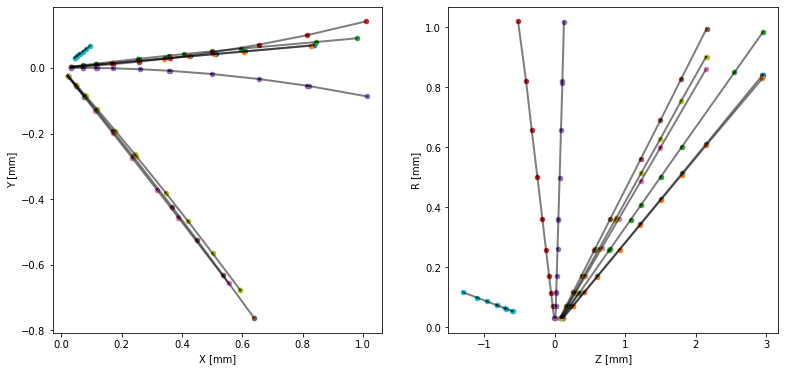

In [129]:
view_graph(data.x, data.pid, data.modulewise_true_edges, max_tracks=10)

only plot the nodes!
randomly select 1373 particles for display
15,187 out of 15198 hits are selected


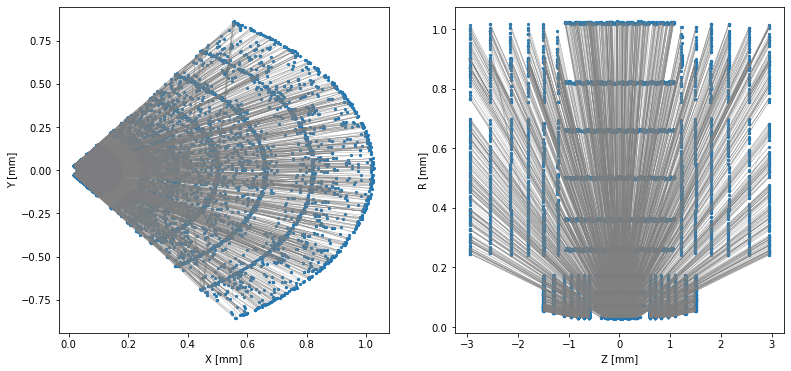

In [131]:
view_graph(data.x, data.pid, data.layerwise_true_edges, max_tracks=-1, markersize=5)

In [20]:
true_edges = data.modulewise_true_edges
num_true_edges = data.modulewise_true_edges.shape[1]
print(num_true_edges)
fake_edges = np.random.randint(data.x.shape[0], size=[2, num_true_edges])

13825


In [91]:
edge_index = torch.tensor(np.concatenate([true_edges, fake_edges], axis=1), dtype=torch.long)
y = torch.tensor(np.concatenate([np.ones(true_edges.shape[1]), np.zeros(fake_edges.shape[1])]), dtype=torch.float32)

perm = torch.randperm(edge_index.shape[1])
edge_index = edge_index[:, perm]
y = y[perm]

## Construct the Edge Classifier

The core component of the Edge Classifier is the Interaction Network. 

In [64]:
def make_mlp(input_size, sizes,
    hidden_activation="ReLU",
    output_activation="ReLU",
    layer_norm=False):
    """Construct an MLP with specified fully-connected layers."""
    hidden_activation = getattr(torch.nn, hidden_activation)
    if output_activation is not None:
        output_activation = getattr(torch.nn, output_activation)
        
    layers = []
    n_layers = len(sizes)
    sizes = [input_size] + sizes
    # Hidden layers
    for i in range(n_layers - 1):
        layers.append(torch.nn.Linear(sizes[i], sizes[i + 1]))
        if layer_norm:
            layers.append(torch.nn.LayerNorm(sizes[i + 1]))
        layers.append(hidden_activation())
    # Final layer
    layers.append(torch.nn.Linear(sizes[-2], sizes[-1]))
    if output_activation is not None:
        if layer_norm:
            layers.append(torch.nn.LayerNorm(sizes[-1]))
        layers.append(output_activation())
    return torch.nn.Sequential(*layers)

class EdgeClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        layer_size = 128
        num_layers = 2
        
        self.node_encoder = make_mlp(3, [layer_size]*num_layers)
        self.edge_encoder = make_mlp(layer_size*2, [layer_size]*num_layers)
        
        self.num_messaging = 4
        self.node_network = make_mlp(layer_size*4, [layer_size]*num_layers)
        self.edge_network = make_mlp(layer_size*4, [layer_size]*num_layers)
        
        self.edge_decoder = make_mlp(layer_size, [layer_size, 1], output_activation=None)
        
    def forward(self, x, edge_index):
        start, end = edge_index
        x = self.node_encoder(x)
        edge = self.edge_encoder(torch.cat([x[start], x[end]], dim=1))
        
        x0 = x
        edge0 = edge
        for _ in range(self.num_messaging):
            sender_edges = scatter_add(edge, start, dim=0, dim_size=x.shape[0])
            receiver_edges = scatter_add(edge, end, dim=0, dim_size=x.shape[0])
            
            x = self.node_network(torch.cat([x0, x, sender_edges, receiver_edges], dim=1))
            edge = self.edge_network(torch.cat([edge0, edge, x[start], x[end]], dim=1))
            
        return self.edge_decoder(edge)

In [65]:
model = EdgeClassifier()
print(model)

EdgeClassifier(
  (node_encoder): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (edge_encoder): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (node_network): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (edge_network): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (edge_decoder): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)


Sanity checks

In [68]:
predictions = model(data.x, edge_index)

## Train the model

In [103]:
criterion = torch.nn.BCEWithLogitsLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Define optimizer.

In [104]:
def train(data):
    optimizer.zero_grad()
    predictions = model(data.x, data.edge_index).squeeze()
    loss = criterion(predictions, data.y)
    loss.backward()
    optimizer.step()
    return loss, predictions

In [125]:
for _ in range(10):
    train_data = Data(x=data.x, edge_index=edge_index, y=y)
    loss, predictions = train(train_data)
    print("{:.4f}".format(loss.detach().numpy()))

0.3306
0.3279
0.3253
0.3227
0.3200
0.3174
0.3147
0.3119
0.3087
0.3049


## Evaluate the performance